# Introduction

This notebook shows how to use variance constrained semi grand canonical (VC-SGC) Molecular Dynamics/Monte Carlo (MD/MC) calculations [1]. This approach has been implemented in Lammps [2] and we have made bindings to it inside pyiron for easy use. 

Here, we show a simple example similar to that used in one of our publications [3], which investigates segregation of Mg to a $\Sigma 5$ tilt grain boundary in Al.

[1] B. Sadigh, P. Erhart, A. Stukowski, A. Caro, E. Martinez, and L. Zepeda-Ruiz, Phys. Rev. B 85, 184203 (2012).

[2] https://vcsgc-lammps.materialsmodeling.org.

[3] Huan Zhao, Liam Huber, et al., Phys. Rev. Lett. 124, 106102 (2020).

# Setup

Imports and so forth.

In [1]:
from pyiron_atomistics import Project
from pyiron_atomistics.vasp.structure import read_atoms
from os.path import join as pjoin
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN

In [2]:
pr = Project('mdmc_demo')
pr.remove_jobs_silently(recursive=True)

# Run simulations

Here we actually run the calculations. First, by relaxing the relevant GB at 0K, then by running VC-SGC MD/MC calculations at high and low temperatures.

The parallelization scheme for VC-SGC means there are lower limits on the structure size we can calculate for. Thus, even using a relatively short run of 20 ps of MD with 500 Monte Carlo phases this calculation takes about ten minutes. Once it's executing, go grab a coffee.

In [3]:
host = 'Al'
solute = 'Mg'
potential = '2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1'

In [4]:
lattice_guess = pr.create_ase_bulk(host, cubic=True).cell[0, 0]
ideal_gb_struct = read_atoms('S5_s001_n210_r1011', species_list=[host, host])
ideal_gb_struct.cell *= lattice_guess
ideal_gb_struct.positions *= lattice_guess

relax_gb_job = pr.create_job(pr.job_type.Lammps, 'relax_gb')
relax_gb_job.potential = potential
relax_gb_job.structure = ideal_gb_struct
relax_gb_job.calc_minimize(f_tol=0.001, pressure=0)
relax_gb_job.run()
gb_struct = relax_gb_job.get_structure().copy()

The job relax_gb was saved and received the ID: 1


In [5]:
gb_struct.plot3d();

In [6]:
mdmc_job = pr.create_job(pr.job_type.Lammps, 'mdmc')
mdmc_job.potential = potential
mdmc_job.structure = gb_struct.repeat([1, 4, 8])
mdmc_job.calc_vcsgc(
    mu={'Al':0, 'Mg':-2}, 
    target_concentration={'Al':0.9, 'Mg':0.1},
    temperature=300,
    pressure=[0.0, 0.0, 0.0],
    n_ionic_steps=10000,
    mc_step_interval=20,
    time_step=2.0,
    langevin=True
)

In [7]:
mdmc_job.run()

The job mdmc was saved and received the ID: 2


# Plotting functions

Just leave this collapsed unless you're really keen.

In [8]:
def plot_average_occupation(struct, eps=0.5, min_samples=5, 
                            columnar_axis=2, max_in_col=9, 
                            size=200, figsize=(30, 10), fontsize=35,
                            save_name=None, fmt='eps', index1_name='Mg', show_orphans=False):
    """
    For a system with a nice columnar projection, given a VC-SGC job and its minimized final structure, 
    plots the mean occupation of each column (indicated by colour). Atoms which could not be grouped are 
    plotted as black.
    
    `eps` should be tuned to have the minimum number of uncatagorized atoms without assigning more than
    the expected number of atoms to a given column.
    """
    from matplotlib.colors import ListedColormap
    # Project onto the plane
    axes = [0, 1, 2]
    axes.pop(columnar_axis)
    projected_pos = struct.positions[:, axes]
    
    # Cluster by column
    cluster_algo = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_algo.fit(projected_pos)
    column_groups = cluster_algo.labels_
    unique_groups = np.unique(column_groups)
    unique_groups = unique_groups[unique_groups != -1]  # Ignore the 'noisy' group
    
    # Double check that two columns aren't getting lumped together
    group_sizes = [len(column_groups[np.argwhere(column_groups == g).reshape(-1)]) for g in unique_groups]
    for group_size in group_sizes:
        if group_size > max_in_col:
            print("WARNING: Group found with {} members.".format(group_size))

    # Get the average positions
    ungrouped_pos = projected_pos[np.argwhere(column_groups == -1).reshape(-1)]
    column_pos = np.array([np.mean(projected_pos[np.argwhere(column_groups == group).reshape(-1)], axis=0)
                           for group in unique_groups])
    
    # Get the average occupation
    indices = struct.indices
    column_concentration = np.array([np.mean(indices[np.argwhere(column_groups == group).reshape(-1)])
                                     for group in unique_groups])
    
    # Plot
    units = 255
    Al_color = np.array([153/units, 153/units, 153/units])
    Mg_color = np.array([(0/units, 128/units, 255/units)])
    mix_frac = np.linspace(0, 1, 1000)
    cmap = ListedColormap([tuple(((1 - x) * Al_color + x * Mg_color)[0]) for x in mix_frac]) 
    
    fig, ax = plt.subplots(figsize=figsize)
    if show_orphans:
        ax.scatter(ungrouped_pos[:, 0], ungrouped_pos[:, 1], s=size, color='r', marker='s', alpha=0.1)
    cols = ax.scatter(column_pos[:, 0], column_pos[:, 1], c=column_concentration, s=size, cmap=cmap)
    cbar = fig.colorbar(cols, orientation='horizontal')
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('Distance $[\mathrm{\AA}]$', size=fontsize)
    ax.set_ylabel('Distance $[\mathrm{\AA}]$', size=fontsize)
    cbar.ax.set_xlabel('Columnar {} concentration'.format(index1_name), size=fontsize)
    cbar.ax.tick_params(axis='both', which='major', labelsize=fontsize)
    fig.tight_layout()
    if save_name is not None:
        plt.savefig(save_name + '.' + fmt, format=fmt)

# Visualization

Finally, let's take a peek at the results.

Early on, we see that although the Mg atoms are more prevalent near the boundary, they are still spread out somewhat uniformly through the system.

By the end of the simulation, even with this truncated simulation time to account for the fact this is only a demo, the Mg atoms nearly perfectly occupy the planar GB sites, and you can begin to see the columnar checkerboard occupation appearing. Depending on your random seed, you may also see some structural changes at the GB.

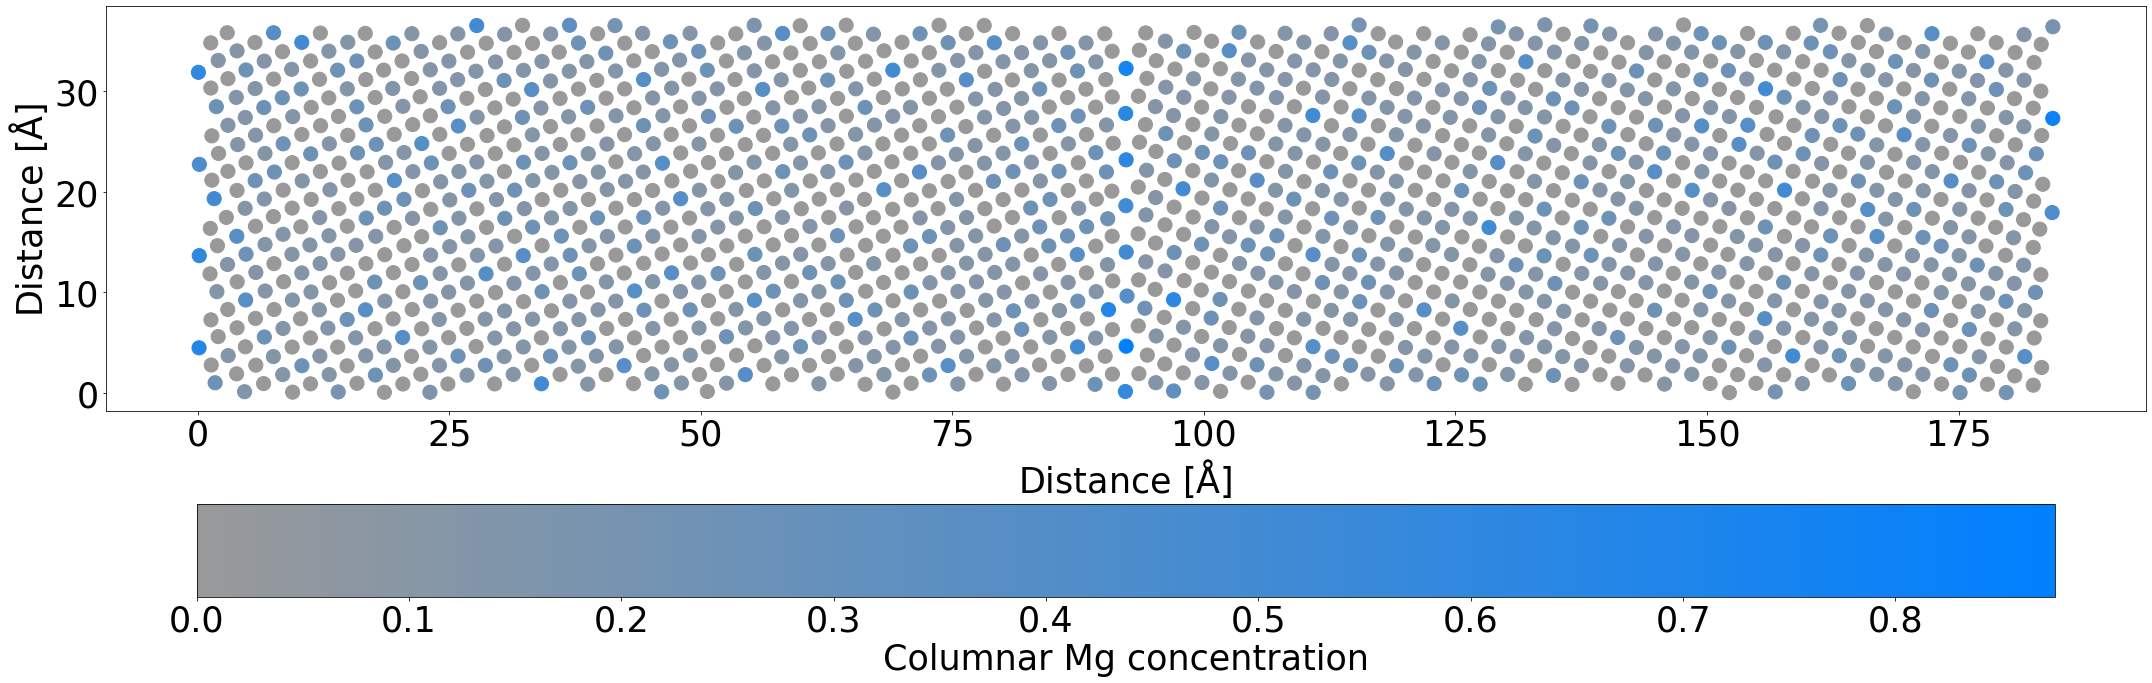

In [9]:
plot_average_occupation(mdmc_job.get_structure(10))

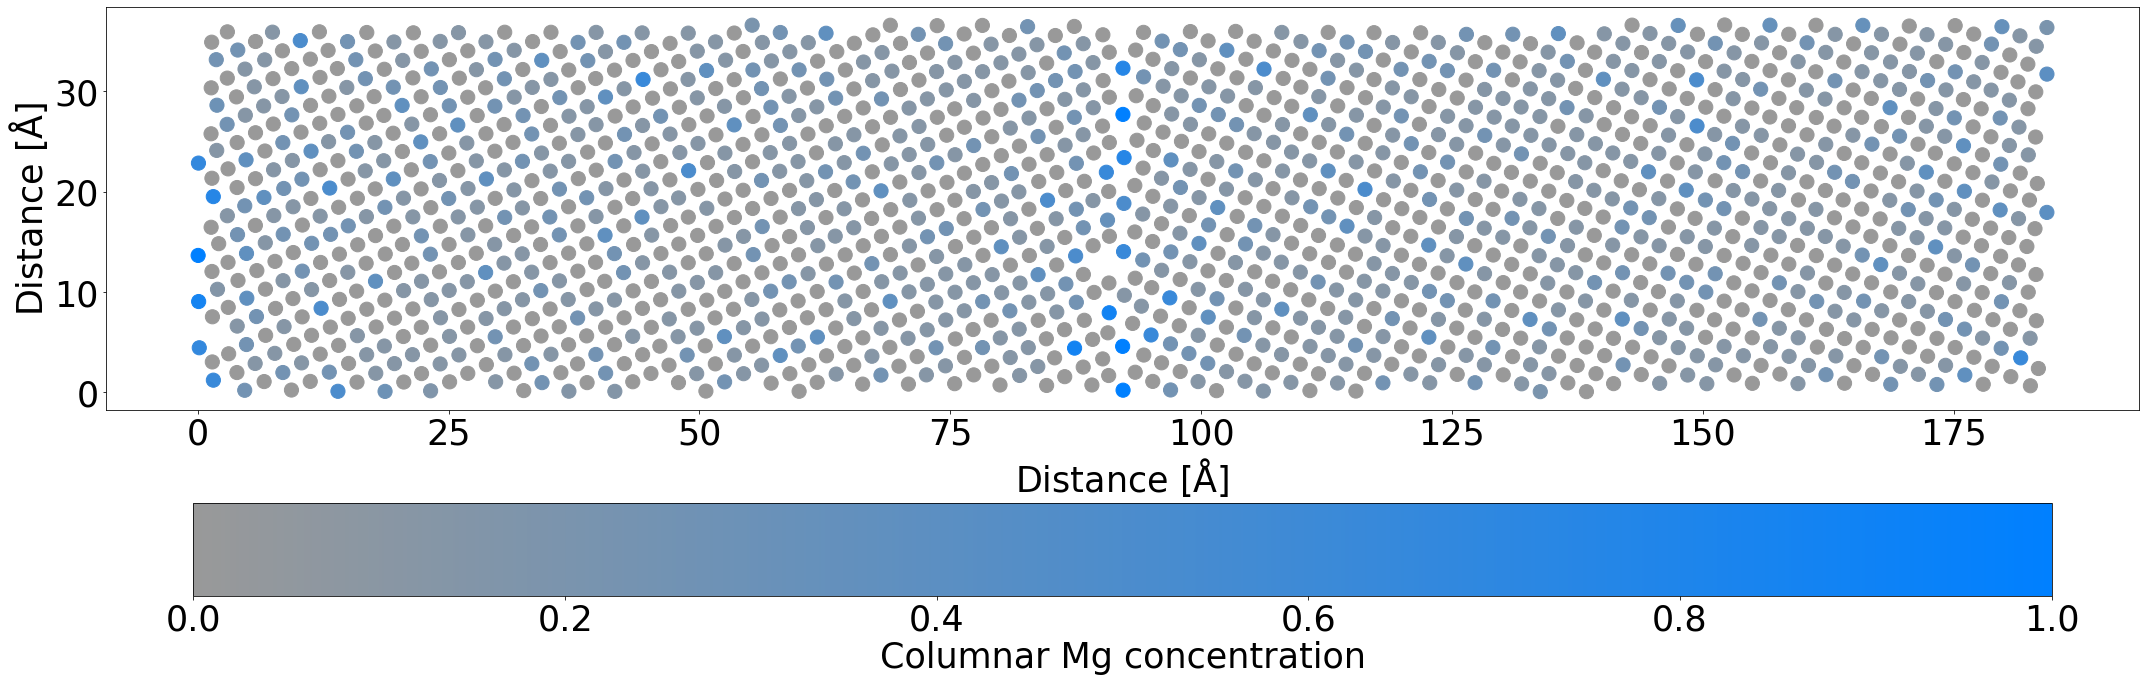

In [10]:
plot_average_occupation(mdmc_job.get_structure(-1))

# Cleanup

This will be commented out to begin with, in case you want to probe the output a little more deeply. But feel free to uncomment and execute whenever you're done with the demo.

In [11]:
# pr.remove_jobs_silently(recursive=True)
# pr.remove(enable=True)